# Load Data

In [ ]:
!pip install netCDF4

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import datetime as dt  # Python standard library datetime  module
import numpy as np
from netCDF4 import Dataset  # http://code.google.com/p/netcdf4-python/
import matplotlib.pyplot as plt
%matplotlib inline
# from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid
import cv2
import numpy.ma as ma
from PIL import Image

In [ ]:
import netCDF4

In [ ]:
from tensorflow import image, float32

In [ ]:
def ncdump(nc_fid, verb=True):
    '''
    ncdump outputs dimensions, variables and their attribute information.
    The information is similar to that of NCAR's ncdump utility.
    ncdump requires a valid instance of Dataset.

    Parameters
    ----------
    nc_fid : netCDF4.Dataset
        A netCDF4 dateset object
    verb : Boolean
        whether or not nc_attrs, nc_dims, and nc_vars are printed

    Returns
    -------
    nc_attrs : list
        A Python list of the NetCDF file global attributes
    nc_dims : list
        A Python list of the NetCDF file dimensions
    nc_vars : list
        A Python list of the NetCDF file variables
    '''
    def print_ncattr(key):
        """
        Prints the NetCDF file attributes for a given key

        Parameters
        ----------
        key : unicode
            a valid netCDF4.Dataset.variables key
        """
        try:
            print ("\t\ttype:", repr(nc_fid.variables[key].dtype))
            for ncattr in nc_fid.variables[key].ncattrs():
                print ('\t\t%s:' %ncattr, repr(nc_fid.variables[key].getncattr(ncattr)))
                ?print(repr(nc_fid.variables[key].getncattr(ncattr)))
        except KeyError:
            print ("\t\tWARNING: %s does not contain variable attributes" % key)

    # NetCDF global attributes
    nc_attrs = nc_fid.ncattrs()
    if verb:
        print ("NetCDF Global Attributes:")
        for nc_attr in nc_attrs:
            print ('\t%s:' % nc_attr, repr(nc_fid.getncattr(nc_attr)))
    nc_dims = [dim for dim in nc_fid.dimensions]  # list of nc dimensions
    # Dimension shape information.
    if verb:
        print ("NetCDF dimension information:")
        for dim in nc_dims:
            print ("\tName:", dim) 
            print ("\t\tsize:", len(nc_fid.dimensions[dim]))
            print_ncattr(dim)
    # Variable information.
    nc_vars = [var for var in nc_fid.variables]  # list of nc variables
    if verb:
        print ("NetCDF variable information:")
        for var in nc_vars:
            if var not in nc_dims:
                print ('\tName:', var)
                print ("\t\tdimensions:", nc_fid.variables[var].dimensions)
                print ("\t\tsize:", nc_fid.variables[var].size)
                print_ncattr(var)
    return nc_attrs, nc_dims, nc_vars

In [ ]:
# nc_f_high='/content/drive/My Drive/sst1km_comp.nc'
nc_f_high = '/content/drive/My Drive/ISRO SAC Off Campus/sst5km.nc'  # Your filename
nc_high = Dataset(nc_f_high, 'r')  # Dataset is the class behavior to open the file
                             # and create an instance of the ncCDF4 class
# nc_attrs, nc_dims, nc_vars = ncdump(nc_high)
# Extract data from NetCDF file
lats = nc_high.variables['LAT'][:]  # extract/copy the data
lons = nc_high.variables['LON'][:]
time = nc_high.variables['TIME'][:]
sst_field_high = nc_high.variables['SST'][:]  # shape is time, lat, lon as shown above

In [ ]:
# nc_f_low = '/content/drive/My Drive/ISRO SAC Off Campus/sst5km.nc'  # Your filename
# nc_f_low = '/content/drive/My Drive/ISRO SAC Off Campus/sst_bicubic.nc'  # Your filename
# nc_f_low='/content/drive/My Drive/ISRO SAC Off Campus/sst_smooth_comp.nc'
nc_f_low="/content/drive/My Drive/ISRO SAC Off Campus/sst25km_sm5km.nc"
nc_low = Dataset(nc_f_low, 'r')  # Dataset is the class behavior to open the file
                             # and create an instance of the ncCDF4 class
# nc_attrs, nc_dims, nc_vars = ncdump(nc_low)
# Extract data from NetCDF file
lats = nc_low.variables['LAT'][:]  # extract/copy the data
lons = nc_low.variables['LON'][:]
time = nc_low.variables['time'][:]
sst_field_low = nc_low.variables['sst'][:]  # shape is time, lat, lon as shown above

In [ ]:
def modify_sst(sst):
  sst_temp=sst.copy()
  missing=sst_temp.fill_value
  for index in range(sst.shape[0]):
    image=sst_temp[index].copy()
    image[image.data==missing]=0
    new_image=ma.masked_equal(image.data, 0)
    sst_temp[index]=new_image
  sst_temp.fill_value=0
  return sst_temp

In [ ]:
sst_high=modify_sst(sst_field_high)

In [ ]:
sst_low=modify_sst(sst_field_low)

In [ ]:
del sst_field_high
del sst_field_low

# Normalise

In [ ]:
max_pixel=max(np.max(sst_high), np.max(sst_low))

In [ ]:
max_pixel #5km-bicubic

28.916999999999973

In [ ]:
max_pixel #5km-25

28.901079999999993

In [ ]:
def normalise(sst, norm_constant=max_pixel):
  sst=sst/norm_constant
  return sst

In [ ]:
sst_high_norm=normalise(sst_high, max_pixel)

In [ ]:
sst_low_norm=normalise(sst_low, max_pixel)

# Original

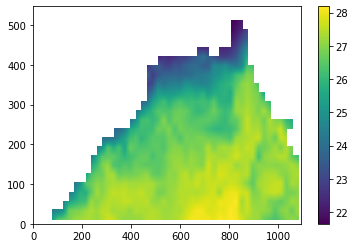

In [ ]:
plt.pcolormesh(sst_low[0])
plt.colorbar()

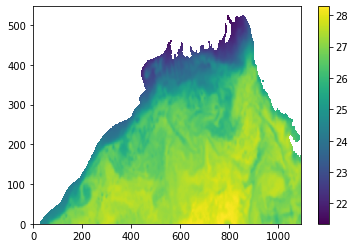

In [ ]:
plt.pcolormesh(sst_high[0])
plt.colorbar()

# Detail Unwanted Arrays

In [ ]:
del sst_high, sst_low

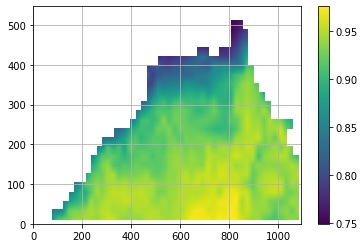

In [ ]:
plt.pcolormesh(sst_low_norm[0])
plt.colorbar()
plt.grid()

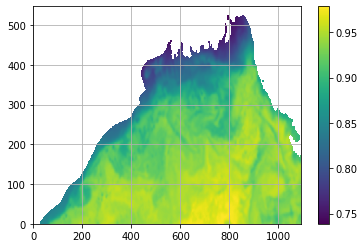

In [ ]:
plt.pcolormesh(sst_high_norm[0])
plt.colorbar()
plt.grid()

# Create Patches

In [ ]:
from sklearn import feature_extraction

In [ ]:
def create_patches(patch_size, max_patches, sst_X, sst_Y, num_fields_end, total, num_fields_start=0):
  
  """this creates patches from the entire sst fields 
  num_fields_start is the start_index, like the start_day
  num_fields_end is the start_index, like the end_day"""

  i=0
  void_array=np.zeros(patch_size)
  train_X=np.zeros((total, void_array.shape[0], void_array.shape[0], 1))
  train_Y=np.zeros((total, void_array.shape[0], void_array.shape[0], 1))
  num_fields_start=int(num_fields_start)
  for index in range(num_fields_start, num_fields_end):
    image_X=sst_X[index].data
    image_Y=sst_Y[index].data
    sub_images_X=feature_extraction.image.extract_patches_2d(image_X, patch_size, max_patches=max_patches, random_state=0)
    sub_images_Y=feature_extraction.image.extract_patches_2d(image_Y, patch_size, max_patches=max_patches, random_state=0)
    for num in range(sub_images_X.shape[0]):
      sub_image_X=sub_images_X[num]
      sub_image_Y=sub_images_Y[num]
      if np.all(sub_image_X!=void_array) and np.all(sub_image_Y!=void_array):
        train_X[i]=sub_image_X.reshape((patch_size[0], patch_size[0], 1))
        train_Y[i]=sub_image_Y.reshape((patch_size[0], patch_size[1], 1))
        i=i+1
        print(i)
      if i==total or index==num_fields_end-1:
        del sub_images_X
        del sub_images_Y
        del void_array
        return train_X, train_Y, i, index, 
    del sub_images_X
    del sub_images_Y


In [ ]:
patch_size=(33, 33) #(66,66) for the 25-5 model

In [ ]:
max_patches=1800

In [ ]:
num_fields_end=220

In [ ]:
total=min(90000, max_patches*num_fields_end) #120000 for the relu-sgd model

In [ ]:
X, Y, values, days=create_patches(patch_size, max_patches, sst_low_norm, sst_high_norm, num_fields_end, total)

Streaming output truncated to the last 5000 lines.
85002
85003
85004
85005
85006
85007
85008
85009
85010
85011
85012
85013
85014
85015
85016
85017
85018
85019
85020
85021
85022
85023
85024
85025
85026
85027
85028
85029
85030
85031
85032
85033
85034
85035
85036
85037
85038
85039
85040
85041
85042
85043
85044
85045
85046
85047
85048
85049
85050
85051
85052
85053
85054
85055
85056
85057
85058
85059
85060
85061
85062
85063
85064
85065
85066
85067
85068
85069
85070
85071
85072
85073
85074
85075
85076
85077
85078
85079
85080
85081
85082
85083
85084
85085
85086
85087
85088
85089
85090
85091
85092
85093
85094
85095
85096
85097
85098
85099
85100
85101
85102
85103
85104
85105
85106
85107
85108
85109
85110
85111
85112
85113
85114
85115
85116
85117
85118
85119
85120
85121
85122
85123
85124
85125
85126
85127
85128
85129
85130
85131
85132
85133
85134
85135
85136
85137
85138
85139
85140
85141
85142
85143
85144
85145
85146
85147
85148
85149
85150
85151
85152
85153
85154
85155
85156
85157
85158
85159
8

In [ ]:
days, values, patch_size #5-25

(126, 90000, (66, 66))

In [ ]:
def PSNRLoss(y_true, y_pred):
    """
    PSNR is Peek Signal to Noise Ratio, which is similar to mean squared error.
    It can be calculated as
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE)
    When providing an unscaled input, MAXp = 255. Therefore 20 * log10(255)== 48.1308036087.
    However, since we are scaling our input, MAXp = 1. Therefore 20 * log10(1) = 0.
    Thus we remove that component completely and only compute the remaining MSE component.
    """
    y_true=np.clip(y_true, 0, 1)
    y_pred=np.clip(y_pred, 0, 1)
    # # print (type(y_true))
    im1 = image.convert_image_dtype(y_true, float32)
    im2 = image.convert_image_dtype(y_pred, float32)
    # psnr2 = image.psnr(im2, im1, max_val=1.0)
    # return psnr2
    # # return -10. * K.log(K.mean(K.square(y_pred - y_true))) / K.log(10.)
    return -10. * np.log(np.mean(np.square(im2 - im1))) / np.log(10.)

In [ ]:
PSNRLoss(X,Y)

46.744902304200984

# Save the Created Arrays

In [ ]:
import h5py

In [ ]:
h5f = h5py.File('low_1800patches_126days.h5', 'w')
h5f.create_dataset('samples', data=X)
h5f.close()

In [ ]:
h5f = h5py.File('high_1800patches_126days.h5', 'w')
h5f.create_dataset('samples', data=Y)
h5f.close()

In [ ]:
!cp 'low_1800patches_126days.h5' '/content/drive/My Drive/ISRO SAC Off Campus/5-25km/'

In [ ]:
!cp 'high_1800patches_126days.h5' '/content/drive/My Drive/ISRO SAC Off Campus/5-25km/'

# Check Patches

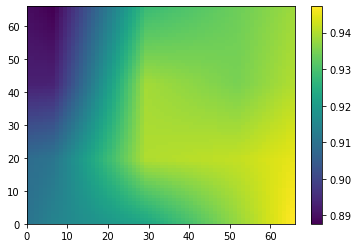

In [ ]:
plt.pcolormesh(X[12].reshape((66,66)))
plt.colorbar()
# plt.clim(vmin=0.7, vmax=1)

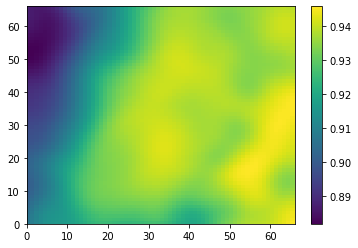

In [ ]:
plt.pcolormesh(Y[12].reshape((66,66)))
plt.colorbar()